In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn-darkgrid')

%matplotlib inline

In [2]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
len(train)

27481

**Q.** Are there any missing values?

In [4]:
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

**A.** Yes, one missing value

Since there is only one missing value, we just drop it.

In [5]:
train.dropna(inplace=True)

**Q.** What is the distribution of sentiments across tweets?

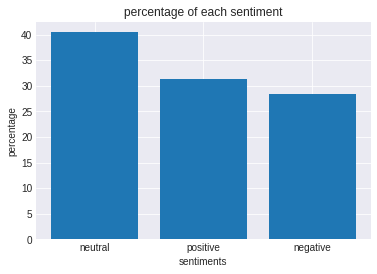

In [6]:
series = train['sentiment'].value_counts(normalize=True) * 100
index, values = series. index,series.values

plt.bar(index, values)
plt.xlabel('sentiments')
plt.ylabel('percentage')
plt.title('percentage of each sentiment')
plt.show()

**Q.** Are there any duplicate rows?

In [7]:
train.duplicated().any()

False

**A.** No duplicate rows

In [8]:
def jaccard(str1, str2):
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return len(c) / (len(a) + len(b) - len(c))

We now check the Jaccard similirity between `text` and `selected_text`

In [9]:
train['jaccard'] = train.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)

**Distribution of Jaccard similirity across sentiments**
- neutral

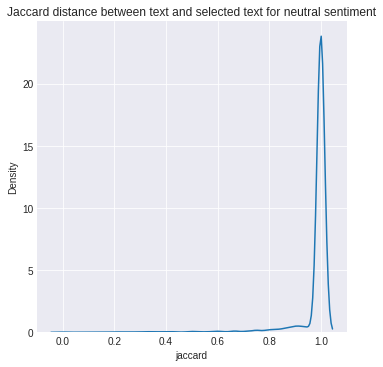

In [10]:
sns.displot(data=train[train['sentiment'] == 'neutral'], x='jaccard', kind='kde')
plt.title('Jaccard distance between text and selected text for neutral sentiment')
plt.show()

It seems that most neutral texts have a jaccard similirity around 1

* positive and negative

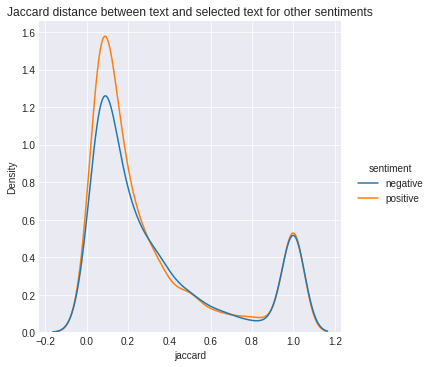

In [11]:
sns.displot(data=train[train['sentiment'] != 'neutral'], x='jaccard', hue='sentiment', kind='kde')
plt.title('Jaccard distance between text and selected text for other sentiments')
plt.show()

**Q.** Is there any pair of `text` and `selected_text` which are completely dissimilar?

In [12]:
(train['jaccard'] == 0).sum() / len(train)

0.02081513828238719

**A.** About 0.2%

These pairs have 0 Jaccard similirity score

In [13]:
train.loc[train['jaccard'] == 0, ['text', 'selected_text']]

,text,selected_text
18,is back home now gonna miss every one,onna
64,mannnn..... _ got an iphone!!! im jealous.... ...,jealous..
66,He`s awesome... Have you worked with him bef...,s awesome
102,"1 week post my'horrible, traumatic jumping cho...","horrible,"
116,graduation is done im a little sad.. anyone w...,sad.
...,...,...
27362,"just found out I won`t be tweeting from ,my ph...","c, sorr"
27376,Going to church in the morning...happy mommas ...,happy
27386,#vwll2009 Would one of the VWLLers want to add...,ch appreciat
27396,Just got refused a bottle of morgan`s in tesco...,shocking.


**Q.** What about Jaccard score of 1?

In [14]:
(train['jaccard'] == 1).sum() / len(train)

0.44683406113537116

**A.** About 45% of the data has a jaccard score of 1

**Q.** What sentiment has the most jaccard score = 1?

In [15]:
train.loc[train['jaccard'] == 1, 'sentiment'].value_counts(normalize=True)

neutral     0.815376
negative    0.093086
positive    0.091538
Name: sentiment, dtype: float64

**A.** `neutral` has 81% of all tweets with jaccard score = 1

**Q.** What percentage of neutral tweets have a jaccard score of 1?

In [16]:
train.loc[train['sentiment'] == 'neutral', 'jaccard'].value_counts(normalize=True).iloc[:10]

1.000000    0.900603
0.857143    0.004678
0.750000    0.004498
0.875000    0.004408
0.800000    0.004318
0.833333    0.004228
0.900000    0.004228
0.909091    0.003598
0.888889    0.003328
0.666667    0.002968
Name: jaccard, dtype: float64

**A.** About 90%

In [17]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
import nltk

def remove_stopwords(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [t for t in text.split() if t not in stopwords]
    return tokens

train['cleaned_text'] = train['text'].map(clean_text)

train['tokens'] = train['cleaned_text'].map(remove_stopwords)

In [19]:
from collections import Counter

def get_token_counts(data, sentiment):
    if sentiment == 'all':
        subset = data
    else:
        subset = data[data['sentiment'] == sentiment]
    
    all_tokens = [token for tokens in subset['tokens']
                            for token in tokens]
    token_counts = Counter(all_tokens)
    
    return token_counts

In [20]:
def get_n_most_common_tokens(token_counts, num_tokens):
    most_common = {}
    
    for token, count in token_counts.most_common():
        if len(token) > 3:
            most_common[token] = count
            num_tokens -= 1

        if num_tokens == 0:
            break
            
    return most_common

In [21]:
def plot_most_common_tokens(most_common):
    plt.figure(figsize=(10, 12))
    series = pd.Series(most_common.values(), index=most_common.keys())
    index, values = series.index, series.values

    plt.barh(index[::-1], values[::-1])
    plt.show()

In [22]:
def plot_most_common_train_tokens(sentiment='all', num_tokens=20):
    token_counts = get_token_counts(train, sentiment)
    most_common = get_n_most_common_tokens(token_counts, num_tokens)
    plot_most_common_tokens(most_common)

We now plot the frequencies of the most common occuring words in each sentiment

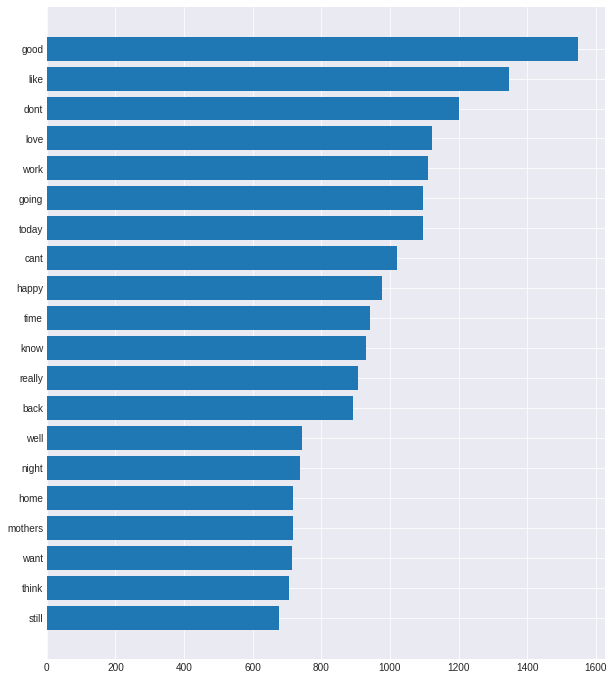

In [23]:
plot_most_common_train_tokens()

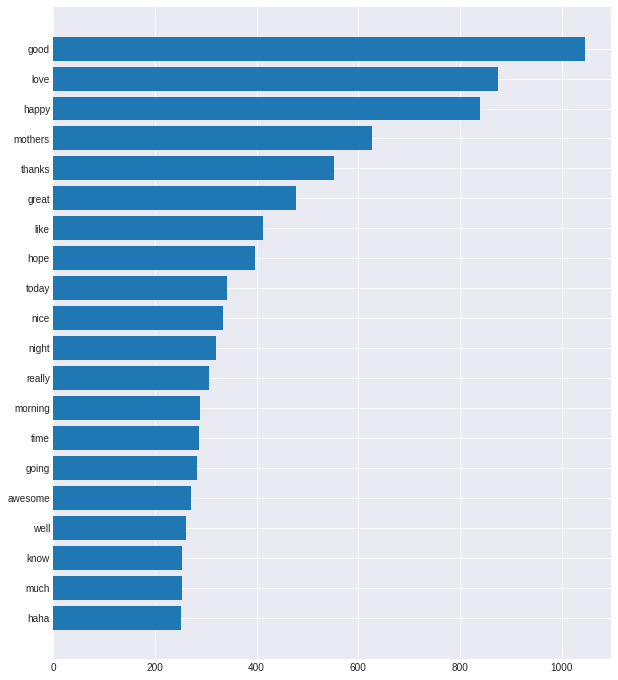

In [24]:
plot_most_common_train_tokens(sentiment='positive')


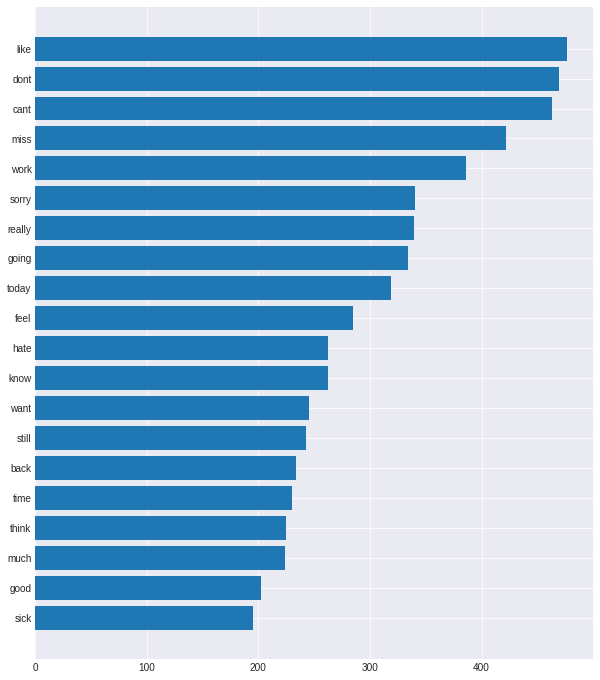

In [25]:
plot_most_common_train_tokens(sentiment='negative')

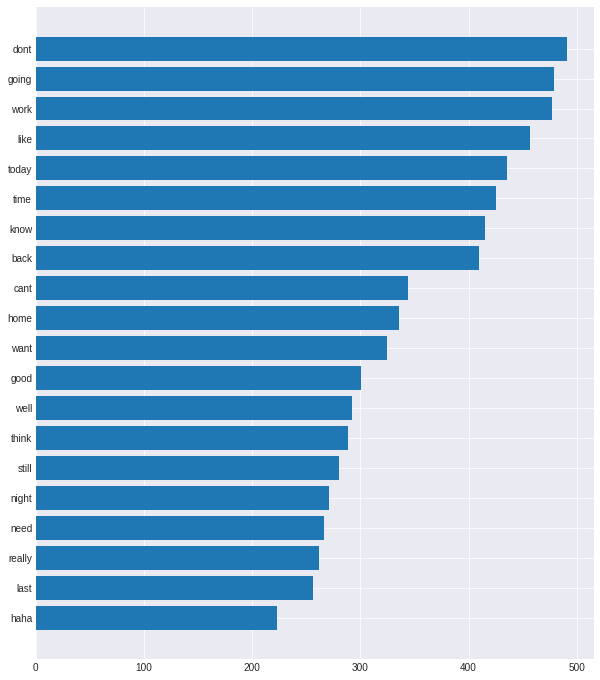

In [26]:
plot_most_common_train_tokens('neutral')

The same is done with words unique to each sentiment

In [27]:
def tokens_unique_to_sentiment(sentiment, num_tokens):
    
    non_sentiment_words = []
    for tokens in train[train['sentiment'] != sentiment]['tokens']:
        for token in tokens:
            non_sentiment_words.append(token)
    non_sentiment_words = set(non_sentiment_words)
            
    sentiment_words = []
    for tokens in train[train['sentiment'] == sentiment]['tokens']:
        for token in tokens:
            if token not in non_sentiment_words:
                sentiment_words.append(token)
    
    sentiment_words = Counter(sentiment_words)
    return dict(sentiment_words.most_common(num_tokens))

In [28]:
def plot_tokens_unique_to_sentiment(sentiment, num_tokens=20):
    tokens = tokens_unique_to_sentiment(sentiment, num_tokens)
    plt.figure(figsize=(10, 12))
    series = pd.Series(tokens.values(), index=tokens.keys())
    index, values = series.index, series.values

    plt.barh(index[::-1], values[::-1])
    plt.show()

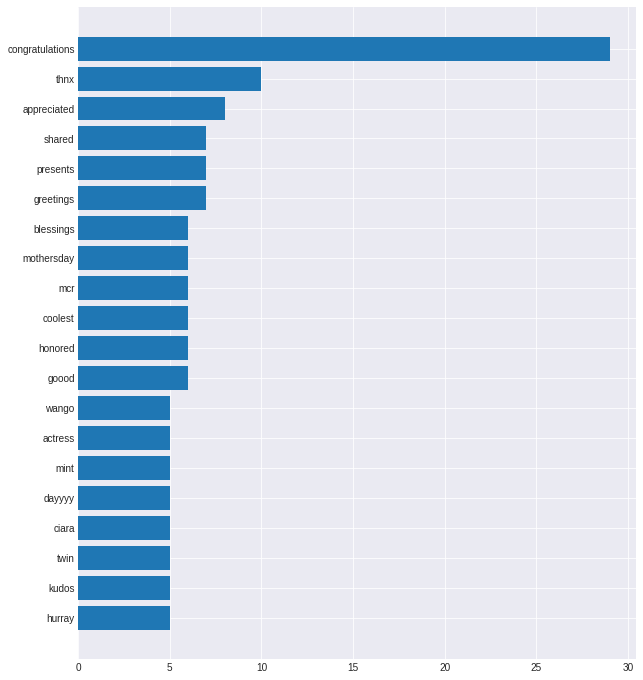

In [29]:
plot_tokens_unique_to_sentiment('positive')

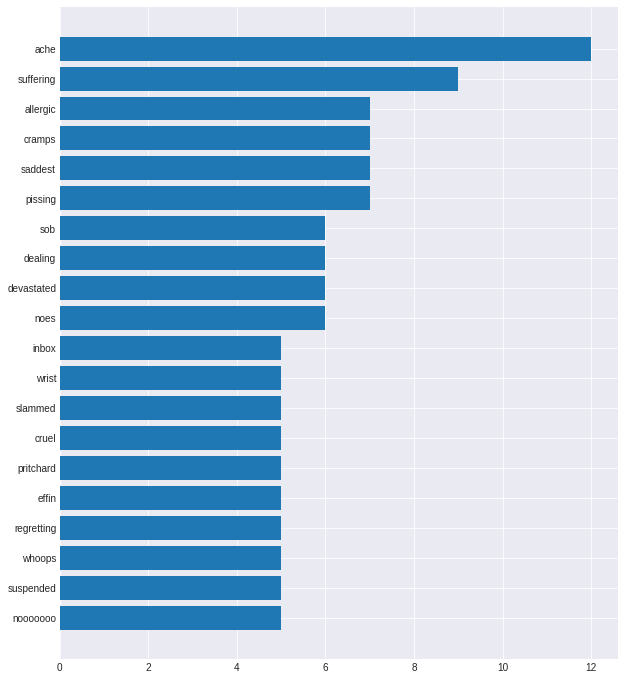

In [30]:
plot_tokens_unique_to_sentiment('negative')


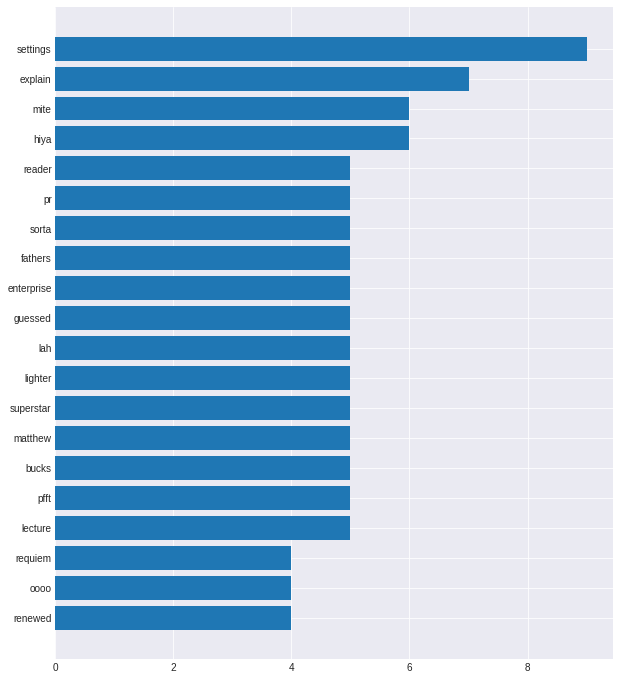

In [31]:
plot_tokens_unique_to_sentiment('neutral')


We found some text mis-aligned when we found a Jaccard score of 0.

**Q.** How many `text` and `selected_text` pairs are mis-alligned?

In [32]:
def check_alignment(data):
    text = data['text']
    selected_text = data['selected_text']
    
    text_words = set(text.split())
    selected_words = selected_text.split()
    
    for word in selected_words:
        if word not in text_words:
            return False
        
    return True

train['is_aligned'] = train.apply(check_alignment, axis=1)

In [33]:
(~train['is_aligned']).sum() / len(train)

0.1057132459970888

**A.** About 10%

In [34]:
not_aligned = train[~train['is_aligned']]
not_aligned[['text', 'selected_text']]

,text,selected_text
2,my boss is bullying me...,bullying me
18,is back home now gonna miss every one,onna
27,On the way to Malaysia...no internet access to...,.no internet
32,If it is any consolation I got my BMI tested ...,well so much for being unhappy for about 10 mi...
39,A little happy for the wine jeje ok it`sm my f...,A little happy fo
...,...,...
27470,lol i know and haha..did you fall asleep?? o...,t bored
27474,So I get up early and I feel good about the da...,I feel good ab
27476,wish we could come see u on Denver husband l...,d lost
27477,I`ve wondered about rake to. The client has ...,", don`t force"


**Q.** How many tweets start or end with an empty space?

In [35]:
train['text'].str.startswith(' ').value_counts(normalize=True)

False    0.600655
True     0.399345
Name: text, dtype: float64

In [36]:
train['text'].str.endswith(' ').value_counts(normalize=True)

False    0.996252
True     0.003748
Name: text, dtype: float64

**A.** About 40% of the tweets starts with a space. Almost none ends with one.